In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

In [5]:
spark = SparkSession.builder.appName("CSVLoadjuly").getOrCreate()

In [6]:
df = spark.read.csv(path="july.csv",sep=",",header = True,quote='"',inferSchema = True)

In [7]:
df.show(1)

+--------+--------------------+--------+--------------------+--------------------+--------+---------+-------+--------------------+------------+--------------------+--------------+------+----------------+--------+--------------------+--------------------+--------------------+-----+
|cord_uid|                 sha|source_x|               title|                 doi|   pmcid|pubmed_id|license|            abstract|publish_time|             authors|       journal|mag_id|who_covidence_id|arxiv_id|      pdf_json_files|      pmc_json_files|                 url|s2_id|
+--------+--------------------+--------+--------------------+--------------------+--------+---------+-------+--------------------+------------+--------------------+--------------+------+----------------+--------+--------------------+--------------------+--------------------+-----+
|ug7v899j|d1aafb70c066a2068...|     PMC|Clinical features...|10.1186/1471-2334...|PMC35282| 11472636|  no-cc|OBJECTIVE: This r...|  2001-07-04|Madani, Tar

In [8]:
df.printSchema()

root
 |-- cord_uid: string (nullable = true)
 |-- sha: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- title: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- pmcid: string (nullable = true)
 |-- pubmed_id: string (nullable = true)
 |-- license: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- mag_id: string (nullable = true)
 |-- who_covidence_id: string (nullable = true)
 |-- arxiv_id: string (nullable = true)
 |-- pdf_json_files: string (nullable = true)
 |-- pmc_json_files: string (nullable = true)
 |-- url: string (nullable = true)
 |-- s2_id: string (nullable = true)



In [9]:
df.count()


169821

In [10]:
df.columns

['cord_uid',
 'sha',
 'source_x',
 'title',
 'doi',
 'pmcid',
 'pubmed_id',
 'license',
 'abstract',
 'publish_time',
 'authors',
 'journal',
 'mag_id',
 'who_covidence_id',
 'arxiv_id',
 'pdf_json_files',
 'pmc_json_files',
 'url',
 's2_id']

In [12]:
for col in df.columns:
    df.describe([col]).show()

+-------+--------+
|summary|cord_uid|
+-------+--------+
|  count|  169821|
|   mean|Infinity|
| stddev|     NaN|
|    min|000ahtxm|
|    max|zzzlzo0y|
+-------+--------+

+-------+--------------------+
|summary|                 sha|
+-------+--------------------+
|  count|               74118|
|   mean|                null|
| stddev|                null|
|    min|0001418189999fea7...|
|    max|ffff2fb21d4880b63...|
+-------+--------------------+

+-------+--------+
|summary|source_x|
+-------+--------+
|  count|  169821|
|   mean|    null|
| stddev|    null|
|    min|   ArXiv|
|    max|     WHO|
+-------+--------+

+-------+--------------------+
|summary|               title|
+-------+--------------------+
|  count|              169771|
|   mean|                null|
| stddev|                null|
|    min|"""A Tiered-Syste...|
|    max|﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿Use...|
+-------+--------------------+

+-------+--------------------+
|summary|                 doi|
+-------+--------------------+
|  

In [13]:
for col in df.columns:

    print(col,"\t","with null values:", df.filter(df[col].isNull()).count())

cord_uid 	 with null values: 0
sha 	 with null values: 95703
source_x 	 with null values: 0
title 	 with null values: 50
doi 	 with null values: 42160
pmcid 	 with null values: 89332
pubmed_id 	 with null values: 58664
license 	 with null values: 127
abstract 	 with null values: 45867
publish_time 	 with null values: 110
authors 	 with null values: 5977
journal 	 with null values: 8993
mag_id 	 with null values: 166342
who_covidence_id 	 with null values: 131703
arxiv_id 	 with null values: 164997
pdf_json_files 	 with null values: 93693
pmc_json_files 	 with null values: 109776
url 	 with null values: 29542
s2_id 	 with null values: 28016


In [14]:
columns_to_drop = ['cord_uid','sha','source_x','doi','pmcid','pubmed_id','license','mag_id',
                   'who_covidence_id','arxiv_id','pdf_json_files','pmc_json_files','url','s2_id']

df2 = df.drop(*columns_to_drop)
df2.columns

['title', 'abstract', 'publish_time', 'authors', 'journal']

In [15]:
df2=df2.dropDuplicates()
df2.count()
df2.show(5)

+--------------------+--------------------+------------+--------------------+--------------------+
|               title|            abstract|publish_time|             authors|             journal|
+--------------------+--------------------+------------+--------------------+--------------------+
|Clinical features...|OBJECTIVE: This r...|  2001-07-04|Madani, Tariq A; ...|      BMC Infect Dis|
|Nitric oxide: a p...|Inflammatory dise...|  2000-08-15|Vliet, Albert van...|          Respir Res|
|Surfactant protei...|Surfactant protei...|  2000-08-25|     Crouch, Erika C|          Respir Res|
|Role of endotheli...|Endothelin-1 (ET-...|  2001-02-22|Fagan, Karen A; M...|          Respir Res|
|Gene expression i...|Respiratory syncy...|  2001-05-11|Domachowske, Jose...|          Respir Res|
|Sequence requirem...|Nidovirus subgeno...|  2001-12-17|Pasternak, Alexan...|    The EMBO Journal|
|Debate: Transfusi...|Recent evidence s...|  2001-03-08|Alvarez, Gonzalo;...|           Crit Care|
|The 21st 

#### Problem 1: Find the 5 most common journals, list them along with their frequencies.

In [18]:
df_journal_count = df2.select("journal").groupBy("journal").count()

df_journal_count = df_journal_count.na.drop()

df_journal_count.sort("count",ascending= False).show(5)


+-------------------+-----+
|            journal|count|
+-------------------+-----+
|           PLoS One| 1774|
|            bioRxiv| 1669|
|                BMJ| 1594|
|Journal of virology| 1561|
|             Lancet|  941|
+-------------------+-----+
only showing top 5 rows



#### problem 2 The top 5 average abstract lengths (number of words) per journal.

In [20]:
df_journal = df2.select("journal","abstract")
df_journal = df_journal.na.drop()
df_journal.show(5)

+-----------------+--------------------+
|          journal|            abstract|
+-----------------+--------------------+
|      PLoS Pathog|The type I interf...|
|         PLoS One|Reverse transcrip...|
|Nucleic Acids Res|Fast viral adapta...|
|         PLoS One|Type I interferon...|
|         PLoS One|BACKGROUND: As of...|
+-----------------+--------------------+
only showing top 5 rows



In [21]:
#df_journal.groupBy("publish_time").count().show()

In [22]:
# df_journal2 = df_journal.groupBy("publish_time")
df_journal2 = df_journal.withColumn("frequency",f.size(f.split(f.col('abstract'), ' '))).sort("frequency",ascending = False)
df_journal2.show(5)

+--------------------+--------------------+---------+
|             journal|            abstract|frequency|
+--------------------+--------------------+---------+
|World Allergy Org...|A1 Pirfenidone in...|    18000|
|  Ann Intensive Care|PHYSICIANS ABSTRA...|    15448|
|           Crit Care|P001 - Sepsis imp...|    12745|
|        BMC Genomics|O1 Regulation of ...|     4642|
|    Int J Infect Dis|Abstract Objectiv...|     3783|
+--------------------+--------------------+---------+
only showing top 5 rows



In [23]:
df_journal3 = df_journal2.select("journal","frequency")
df_journal3 = df_journal3.groupBy("journal").sum().sort("sum(frequency)",ascending = False)
df_journal3.show(5)

+-------------------+--------------+
|            journal|sum(frequency)|
+-------------------+--------------+
|           PLoS One|        426190|
|Journal of virology|        368256|
|            bioRxiv|        345228|
| Surgical endoscopy|        227346|
|           Virology|        156470|
+-------------------+--------------+
only showing top 5 rows



In [24]:
# combine Prob 1 with total frequency

df_combine = df_journal3.join(df_journal_count,"journal","outer").select("journal","sum(frequency)","count")
df_combine.show(10)

+--------------------+--------------+-----+
|             journal|sum(frequency)|count|
+--------------------+--------------+-----+
|        0.76; 95% CI|           116|    1|
| 2020. Of these w...|            19|    1|
| a tracking and r...|           215|    1|
| after collecting...|            83|    1|
| airborne infections|            78|    1|
| and operative ti...|            71|    1|
| despite little e...|            88|    1|
| drug repurposing...|            83|    1|
| given the key ro...|           133|    1|
| has also been pr...|            52|    1|
+--------------------+--------------+-----+
only showing top 10 rows



In [25]:
df_combine = df_combine.withColumn("Avg_word",(f.col("sum(frequency)")/f.col("count")))
df_combine = df_combine.drop("sum(frequency)","count")
df_combine.sort("Avg_word",ascending = False).show(5)

+--------------------+------------------+
|             journal|          Avg_word|
+--------------------+------------------+
|Absolute Neurocri...|            2232.0|
|World Allergy Org...|1795.8181818181818|
|Endocrine, metabo...|            1504.0|
|National Toxicolo...|           1301.75|
|Cochrane Database...| 954.7142857142857|
+--------------------+------------------+
only showing top 5 rows



#### Problem 3: Titles of the 5 papers with the highest numbers of authors. Both the numbers of authors and the corresponding titles need to be output.

In [26]:
df_title_auth = df2.select("title","authors")
df_title_auth.show(5)

+--------------------+--------------------+
|               title|             authors|
+--------------------+--------------------+
|Influenza A Virus...|Pauli, Eva-K.; Sc...|
|The Y271 and I274...|Zhang, Hao-Jie; W...|
|PhEVER: a databas...|Palmeira, Leonor;...|
|A Vesicular Stoma...|Berger Rentsch, M...|
|Geographic Distri...|Liu, Yunning; Wan...|
+--------------------+--------------------+
only showing top 5 rows



In [27]:

df_title_auth = df_title_auth.withColumn("Nauthors",f.size(f.split(f.col('authors'), ';')))
df_title_auth = df_title_auth.drop("authors")
df_title_auth.sort("Nauthors",ascending = False).show(5)

+--------------------+--------+
|               title|Nauthors|
+--------------------+--------+
|XXIV World Allerg...|    3572|
|ESICM LIVES 2016:...|    2621|
|ESICM LIVES 2016:...|    2500|
|ESICM LIVES 2016:...|    2446|
|36th Internationa...|    2440|
+--------------------+--------+
only showing top 5 rows



#### Problem 4: The top 5 most prolific authors along with the number of papers they have contributed to

In [28]:
df_profilic = df2.select("authors","journal")
df_profilic.show()

+--------------------+--------------------+
|             authors|             journal|
+--------------------+--------------------+
|Pauli, Eva-K.; Sc...|         PLoS Pathog|
|Zhang, Hao-Jie; W...|            PLoS One|
|Palmeira, Leonor;...|   Nucleic Acids Res|
|Berger Rentsch, M...|            PLoS One|
|Liu, Yunning; Wan...|            PLoS One|
|Gad, Yahia Z.; Mo...|Asian J Transfus Sci|
|Phan, Tung Gia; V...|            PLoS One|
|Kgaladi, Joe; Wri...|  PLoS Negl Trop Dis|
|Ray, Bridgette N....|      Mol Endocrinol|
|Wang, Dingming; T...|      J Med Case Rep|
|Garg, Shikha; Jai...|      BMC Infect Dis|
|Li, Ling; Long, J...|   J Orthop Translat|
|Rojek, Amanda M; ...|     Clin Infect Dis|
|Balloux, Francois...|    Trends Microbiol|
|Wang, Yingchen; D...|     Front Microbiol|
|Lee, Cheng-Chung;...|             Sci Rep|
|Stenzel, Tomasz; ...|            PLoS One|
|ten Hoeve, Arne L...|Front Cell Infect...|
|Hulst, M.M.; Here...|    J Appl Microbiol|
|Bandosz, Piotr; A...|        Di

In [29]:
df_profilic2 = df_profilic.withColumn("AllAutors",f.explode(f.split(f.col('authors'), ';')))

df_profilic2 = df_profilic2.withColumn("Authors",f.trim(df_profilic2.AllAutors))
df_profilic2 = df_profilic2.drop("ALLAutors")
df_profilic2.show()

+--------------------+-----------------+
|             Authors|          journal|
+--------------------+-----------------+
|       Pauli, Eva-K.|      PLoS Pathog|
|     Schmolke, Mirco|      PLoS Pathog|
|     Wolff, Thorsten|      PLoS Pathog|
|   Viemann, Dorothee|      PLoS Pathog|
|      Roth, Johannes|      PLoS Pathog|
|   Bode, Johannes G.|      PLoS Pathog|
|     Ludwig, Stephan|      PLoS Pathog|
|      Zhang, Hao-Jie|         PLoS One|
|    Wang, Yong-Xiang|         PLoS One|
|             Wu, Hao|         PLoS One|
|       Jin, Dong-Yan|         PLoS One|
|         Wen, Yu-Mei|         PLoS One|
|      Zheng, Bo-Jian|         PLoS One|
|    Palmeira, Leonor|Nucleic Acids Res|
|        Penel, Simon|Nucleic Acids Res|
|    Lotteau, Vincent|Nucleic Acids Res|
|Rabourdin-Combe, ...|Nucleic Acids Res|
|  Gautier, Christian|Nucleic Acids Res|
|Berger Rentsch, M...|         PLoS One|
|        Zimmer, Gert|         PLoS One|
+--------------------+-----------------+
only showing top

In [30]:
df_profilic2.groupBy("Authors").count().sort("count",ascending = False).show(5)

+------------------+-----+
|           Authors|count|
+------------------+-----+
|   Yuen, Kwok-Yung|  254|
|Drosten, Christian|  226|
|         Wang, Wei|  225|
|             O039,|  218|
|      Jiang, Shibo|  196|
+------------------+-----+
only showing top 5 rows



####  Proble 5: If an author’s H index is computed by summing all the H indexes of the journals they’ve published in (as included in the scimagojr dataset), list the 5 people with the top author H index values. These results use Scimagojr 2019.

In [31]:
# load scimagojor data
df_sci = spark.read.csv(path="scimagojr.csv",sep=";",header = True,quote='"',inferSchema = True)


In [32]:
df_sci.columns

['Rank',
 'Sourceid',
 'Title',
 'Type',
 'Issn',
 'SJR',
 'SJR Best Quartile',
 'H index',
 'Total Docs. (2019)',
 'Total Docs. (3years)',
 'Total Refs.',
 'Total Cites (3years)',
 'Citable Docs. (3years)',
 'Cites / Doc. (2years)',
 'Ref. / Doc.',
 'Country',
 'Region',
 'Publisher',
 'Coverage',
 'Categories']

In [33]:
df_sci2 = df_sci.select("Title","H index","Type")
#df_sci2 = df_sci2.filter(df_sci2.Type == "journal")
df_sci2 = df_sci2.drop("Type")
df_sci2.show(5)

+--------------------+-------+
|               Title|H index|
+--------------------+-------+
|CA - A Cancer Jou...|    156|
|MMWR. Recommendat...|    138|
|Nature Reviews Ma...|     80|
|Quarterly Journal...|    246|
|Nature Reviews Mo...|    411|
+--------------------+-------+
only showing top 5 rows



In [34]:
df_sci_sum=df_sci2.groupBy("Title").sum()
df_sci_sum.sort("sum(H index)",ascending = False).show(5)

+--------------------+------------+
|               Title|sum(H index)|
+--------------------+------------+
|              Nature|        1159|
|             Science|        1124|
|New England Journ...|         987|
|          The Lancet|         747|
|                Cell|         747|
+--------------------+------------+
only showing top 5 rows



In [35]:
# preparing dataset for title and author
df_title = df2.select("authors","title")

df_title = df_title.withColumn("AllAuthors",f.explode(f.split(f.col('authors'), ';')))

df_title = df_title.withColumn("Authors",f.trim(df_title.AllAuthors))
df_title = df_title.drop("ALLAuthors")
df_title.show(5)

+-----------------+--------------------+
|          Authors|               title|
+-----------------+--------------------+
|    Pauli, Eva-K.|Influenza A Virus...|
|  Schmolke, Mirco|Influenza A Virus...|
|  Wolff, Thorsten|Influenza A Virus...|
|Viemann, Dorothee|Influenza A Virus...|
|   Roth, Johannes|Influenza A Virus...|
+-----------------+--------------------+
only showing top 5 rows



In [36]:
# join two tables

df_title_index = df_title.join(df_sci_sum,df_title.title==df_sci_sum.Title,"inner")
df_title_index.sort("sum(H index)",ascending = False).show(10)

+--------------------+--------------------+--------------------+------------+
|             Authors|               title|               Title|sum(H index)|
+--------------------+--------------------+--------------------+------------+
|Christophorou, Lo...|             Science|             Science|        1124|
|      Chopra, Angeli|    Gastroenterology|    Gastroenterology|         386|
|     Mooney, Sean D.|      Bioinformatics|      Bioinformatics|         363|
|     Altman, Russ B.|      Bioinformatics|      Bioinformatics|         363|
|     Altman, Russ B.|      Bioinformatics|      Bioinformatics|         363|
|Tenenbaum, Jessic...|      Bioinformatics|      Bioinformatics|         363|
|     Mooney, Sean D.|      Bioinformatics|      Bioinformatics|         363|
|    Barone, Georgina|           Neurology|           Neurology|         351|
|McArthur, Donna B...|Emerging Infectio...|Emerging Infectio...|         215|
|             Gao, Bo|Emerging Infectio...|Emerging Infectio...|

In [37]:
df_title_index2 = df_title_index.drop("title","Title")
df_title_index2.groupBy("Authors").sum().sort("sum(sum(H index))",ascending = False).show(10)

+--------------------+-----------------+
|             Authors|sum(sum(H index))|
+--------------------+-----------------+
|Christophorou, Lo...|             1124|
|     Altman, Russ B.|              726|
|     Mooney, Sean D.|              726|
|      Chopra, Angeli|              386|
|Tenenbaum, Jessic...|              363|
|    Barone, Georgina|              351|
|     Falke, Dietrich|              327|
|    Schätzl, Hermann|              327|
|     Modrow, Susanne|              327|
|         Truyen, Uwe|              327|
+--------------------+-----------------+
only showing top 10 rows



In [38]:
df_vis = df2.select("publish_time","journal",f.to_date(df2.publish_time).alias("Date"))
df_vis = df_vis.drop("publish_time")
df_vis.show()

+--------------------+----------+
|             journal|      Date|
+--------------------+----------+
|         PLoS Pathog|2008-11-07|
|            PLoS One|2009-07-03|
|   Nucleic Acids Res|2010-11-16|
|            PLoS One|2011-10-05|
|            PLoS One|2011-10-12|
|Asian J Transfus Sci|2012-01-01|
|            PLoS One|2013-09-04|
|  PLoS Negl Trop Dis|2013-10-24|
|      Mol Endocrinol|2012-05-08|
|      J Med Case Rep|2015-05-12|
|      BMC Infect Dis|2015-08-26|
|   J Orthop Translat|2017-07-17|
|     Clin Infect Dis|2018-05-01|
|    Trends Microbiol|2018-12-01|
|     Front Microbiol|2018-11-27|
|             Sci Rep|2019-03-14|
|            PLoS One|2019-06-28|
|Front Cell Infect...|2019-10-11|
|    J Appl Microbiol|2019-04-01|
|        Diabetologia|2019-11-15|
+--------------------+----------+
only showing top 20 rows



#### Problem 6 : Plot the number of papers per month since 2020-01. You need to include your visualization as well as a table of the values you have plotted for each month.

In [39]:
df_vis = df_vis.withColumn("Year",f.split(df_vis.Date,"-").getItem(0)).withColumn("Month",f.split(df_vis.Date,"-").getItem(1))
df_vis.show(5,truncate = False)

+-----------------+----------+----+-----+
|journal          |Date      |Year|Month|
+-----------------+----------+----+-----+
|PLoS Pathog      |2008-11-07|2008|11   |
|PLoS One         |2009-07-03|2009|07   |
|Nucleic Acids Res|2010-11-16|2010|11   |
|PLoS One         |2011-10-05|2011|10   |
|PLoS One         |2011-10-12|2011|10   |
+-----------------+----------+----+-----+
only showing top 5 rows



In [40]:
df_vis = df_vis.filter(df_vis.Year >= 2020)
df_vis = df_vis.drop("Date")
df_vis.show(10)

+--------------------+----+-----+
|             journal|Year|Month|
+--------------------+----+-----+
|           Crit Care|2020|   02|
|       Int J Mol Sci|2020|   02|
|  Int J Health Geogr|2020|   04|
|             Virol J|2020|   04|
|         Eur Heart J|2020|   02|
|           J Nat Med|2020|   01|
|              Hernia|2020|   01|
|        World J Surg|2020|   04|
|Appl Microbiol Bi...|2020|   01|
|             Sci Rep|2020|   05|
+--------------------+----+-----+
only showing top 10 rows



In [41]:
df_vis2 = df_vis.select("journal",f.concat(df_vis.Year,f.lit("-"),df_vis.Month).alias("Date"))
df_vis2.show(5)

+------------------+-------+
|           journal|   Date|
+------------------+-------+
|         Crit Care|2020-02|
|     Int J Mol Sci|2020-02|
|Int J Health Geogr|2020-04|
|           Virol J|2020-04|
|       Eur Heart J|2020-02|
+------------------+-------+
only showing top 5 rows



In [42]:
df_vis3 = df_vis2.groupBy("Date").count().sort("Date")
df_vis3.show()

+-------+-----+
|   Date|count|
+-------+-----+
|2020-01|29288|
|2020-02| 1580|
|2020-03| 4301|
|2020-04|11597|
|2020-05|16974|
|2020-06|13218|
|2020-07|  200|
|2020-08|   61|
|2020-09|   22|
|2020-10|   16|
|2020-11|   13|
|2020-12|  294|
|2021-12|    2|
+-------+-----+



In [43]:
import matplotlib.pyplot as plt
import pandas as pd

In [44]:
df_pandas = df_vis3.toPandas()


In [45]:
df_pandas.head(5)

,Date,count
0,2020-01,29288
1,2020-02,1580
2,2020-03,4301
3,2020-04,11597
4,2020-05,16974


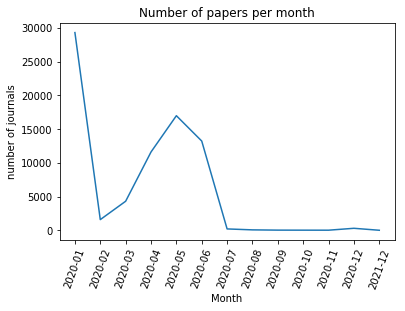

In [46]:
plt.plot(df_pandas["Date"].values,df_pandas["count"].values)

plt.title("Number of papers per month")
plt.xlabel("Month")
plt.ylabel("number of journals")
plt.xticks(rotation=70)
plt.show()